#### Labels transfer of epithelial cell states from gut healthy adult single-cell RNA sequencing cells to Xenium data
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 30th January 2024

##### Import packages

In [1]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import torch
from scvi.model.utils import mde

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Setup cells

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [3]:
%matplotlib inline
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.set_float32_matmul_precision('medium')

In [6]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [7]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

##### Data Upload

In [8]:
input = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/scRNA_and_Xenium_data_scANVI.h5ad'
adata = sc.read_h5ad(input)

In [9]:
X_is_raw(adata)

True

+ Prepare observations column

In [10]:
# Convert 'Cell Type' to object type temporarily
adata.obs['Cell Type'] = adata.obs['Cell Type'].astype('object')

# Perform the copy operation
adata.obs.loc[adata.obs['Cell Type'].isnull(), 'Cell Type'] = adata.obs['C_scANVI']

# Optional: Convert 'Cell Type' back to categorical, if needed
adata.obs['Cell Type'] = adata.obs['Cell Type'].astype('category')


In [11]:
adata.obs['Cell Type'].value_counts()

Cell Type
Epithelial      272767
Mesenchymal      81984
Plasma cells     68088
T cells          52820
Myeloid          42883
Endothelial      23827
B cells          22815
Neuronal          1988
Name: count, dtype: int64

+ Extract epithelial cells

In [12]:
adata = adata[adata.obs['Cell Type'] == 'Epithelial']

In [13]:
adata.obs['seed_labels'] = adata.obs['Cell States'].copy()

/tmp/ipykernel_1605700/2917285804.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['seed_labels'] = adata.obs['Cell States'].copy()


In [14]:
adata.obs['seed_labels'].cat.categories

Index(['BEST2+ Goblet cell', 'BEST4+ epithelial', 'Colonocyte',
       'D cells (SST+)', 'EC cells (TAC1+)', 'EECs', 'Enterochromaffin cells',
       'Enterocyte', 'Enterocytes BEST4', 'Enterocytes CA1 CA2 CA4-',
       'Enterocytes TMIGD1 MEP1A', 'Enterocytes TMIGD1 MEP1A GSTA1',
       'Enteroendocrine cells', 'Epithelial Cycling cells',
       'Epithelial HBB HBA', 'Epithelial cells METTL12 MAFB', 'Goblet cell',
       'Goblet cells MUC2 TFF1', 'Goblet cells MUC2 TFF1-',
       'Goblet cells SPINK4', 'I cells (CCK+)', 'K cells (GIP+)', 'L cells',
       'L cells (PYY+)', 'M/X cells (MLN/GHRL+)', 'Microfold cell',
       'N cells (NTS+)', 'Paneth', 'Paneth cells', 'Progenitor (NEUROG3+)',
       'Stem cells OLFM4', 'Stem cells OLFM4 GSTA1', 'Stem cells OLFM4 LGR5',
       'Stem cells OLFM4 PCNA', 'Stem_Cells_GCA', 'Stem_Cells_ext', 'TA',
       'Tuft', 'Tuft cells'],
      dtype='object')

+ Make cell states more categorized

In [15]:
goblet = ["BEST2+ Goblet cell", "Goblet cell", 'Goblet cells MUC2 TFF1', 'Goblet cells MUC2 TFF1-', 'Goblet cells SPINK4']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(goblet, 'Goblet_cells')

epithelial = ['BEST4+ epithelial', 'Epithelial Cycling cells',
       'Epithelial HBB HBA', 'Epithelial cells METTL12 MAFB']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(epithelial, 'Epithelial_cells')

stem = ['Stem cells OLFM4', 'Stem cells OLFM4 GSTA1', 'Stem cells OLFM4 LGR5',
       'Stem cells OLFM4 PCNA', 'Stem_Cells_GCA', 'Stem_Cells_ext']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(stem, 'Stem_cells')  

enterocytes = ['Enterocyte', 'Enterocytes BEST4', 'Enterocytes CA1 CA2 CA4-','Enterocytes TMIGD1 MEP1A', 'Enterocytes TMIGD1 MEP1A GSTA1']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(enterocytes, 'Enterocytes') 

adata.obs['seed_labels'] = adata.obs['seed_labels'].replace('Tuft', 'Tuft cells')  

adata.obs['seed_labels'] = adata.obs['seed_labels'].replace('Paneth', 'Paneth cells')  

In [16]:
enteroendocrine = ['EC cells (TAC1+)', 'EECs', 'D cells (SST+)', 'I cells (CCK+)', 'K cells (GIP+)', 'L cells',
       'L cells (PYY+)', 'M/X cells (MLN/GHRL+)', 'N cells (NTS+)']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(enteroendocrine, 'Enteroendocrine cells')

In [17]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].cat.add_categories('Unknown')
adata.obs.loc[adata.obs['seed_labels'].isnull(), 'seed_labels'] = 'Unknown'

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Unknown'),
  Text(1, 0, 'Enterocytes'),
  Text(2, 0, 'TA'),
  Text(3, 0, 'Stem_cells'),
  Text(4, 0, 'Goblet_cells'),
  Text(5, 0, 'Colonocyte'),
  Text(6, 0, 'Epithelial_cells'),
  Text(7, 0, 'Paneth cells'),
  Text(8, 0, 'Tuft cells'),
  Text(9, 0, 'Enteroendocrine cells'),
  Text(10, 0, 'Microfold cell'),
  Text(11, 0, 'Enterochromaffin cells'),
  Text(12, 0, 'Progenitor (NEUROG3+)')])

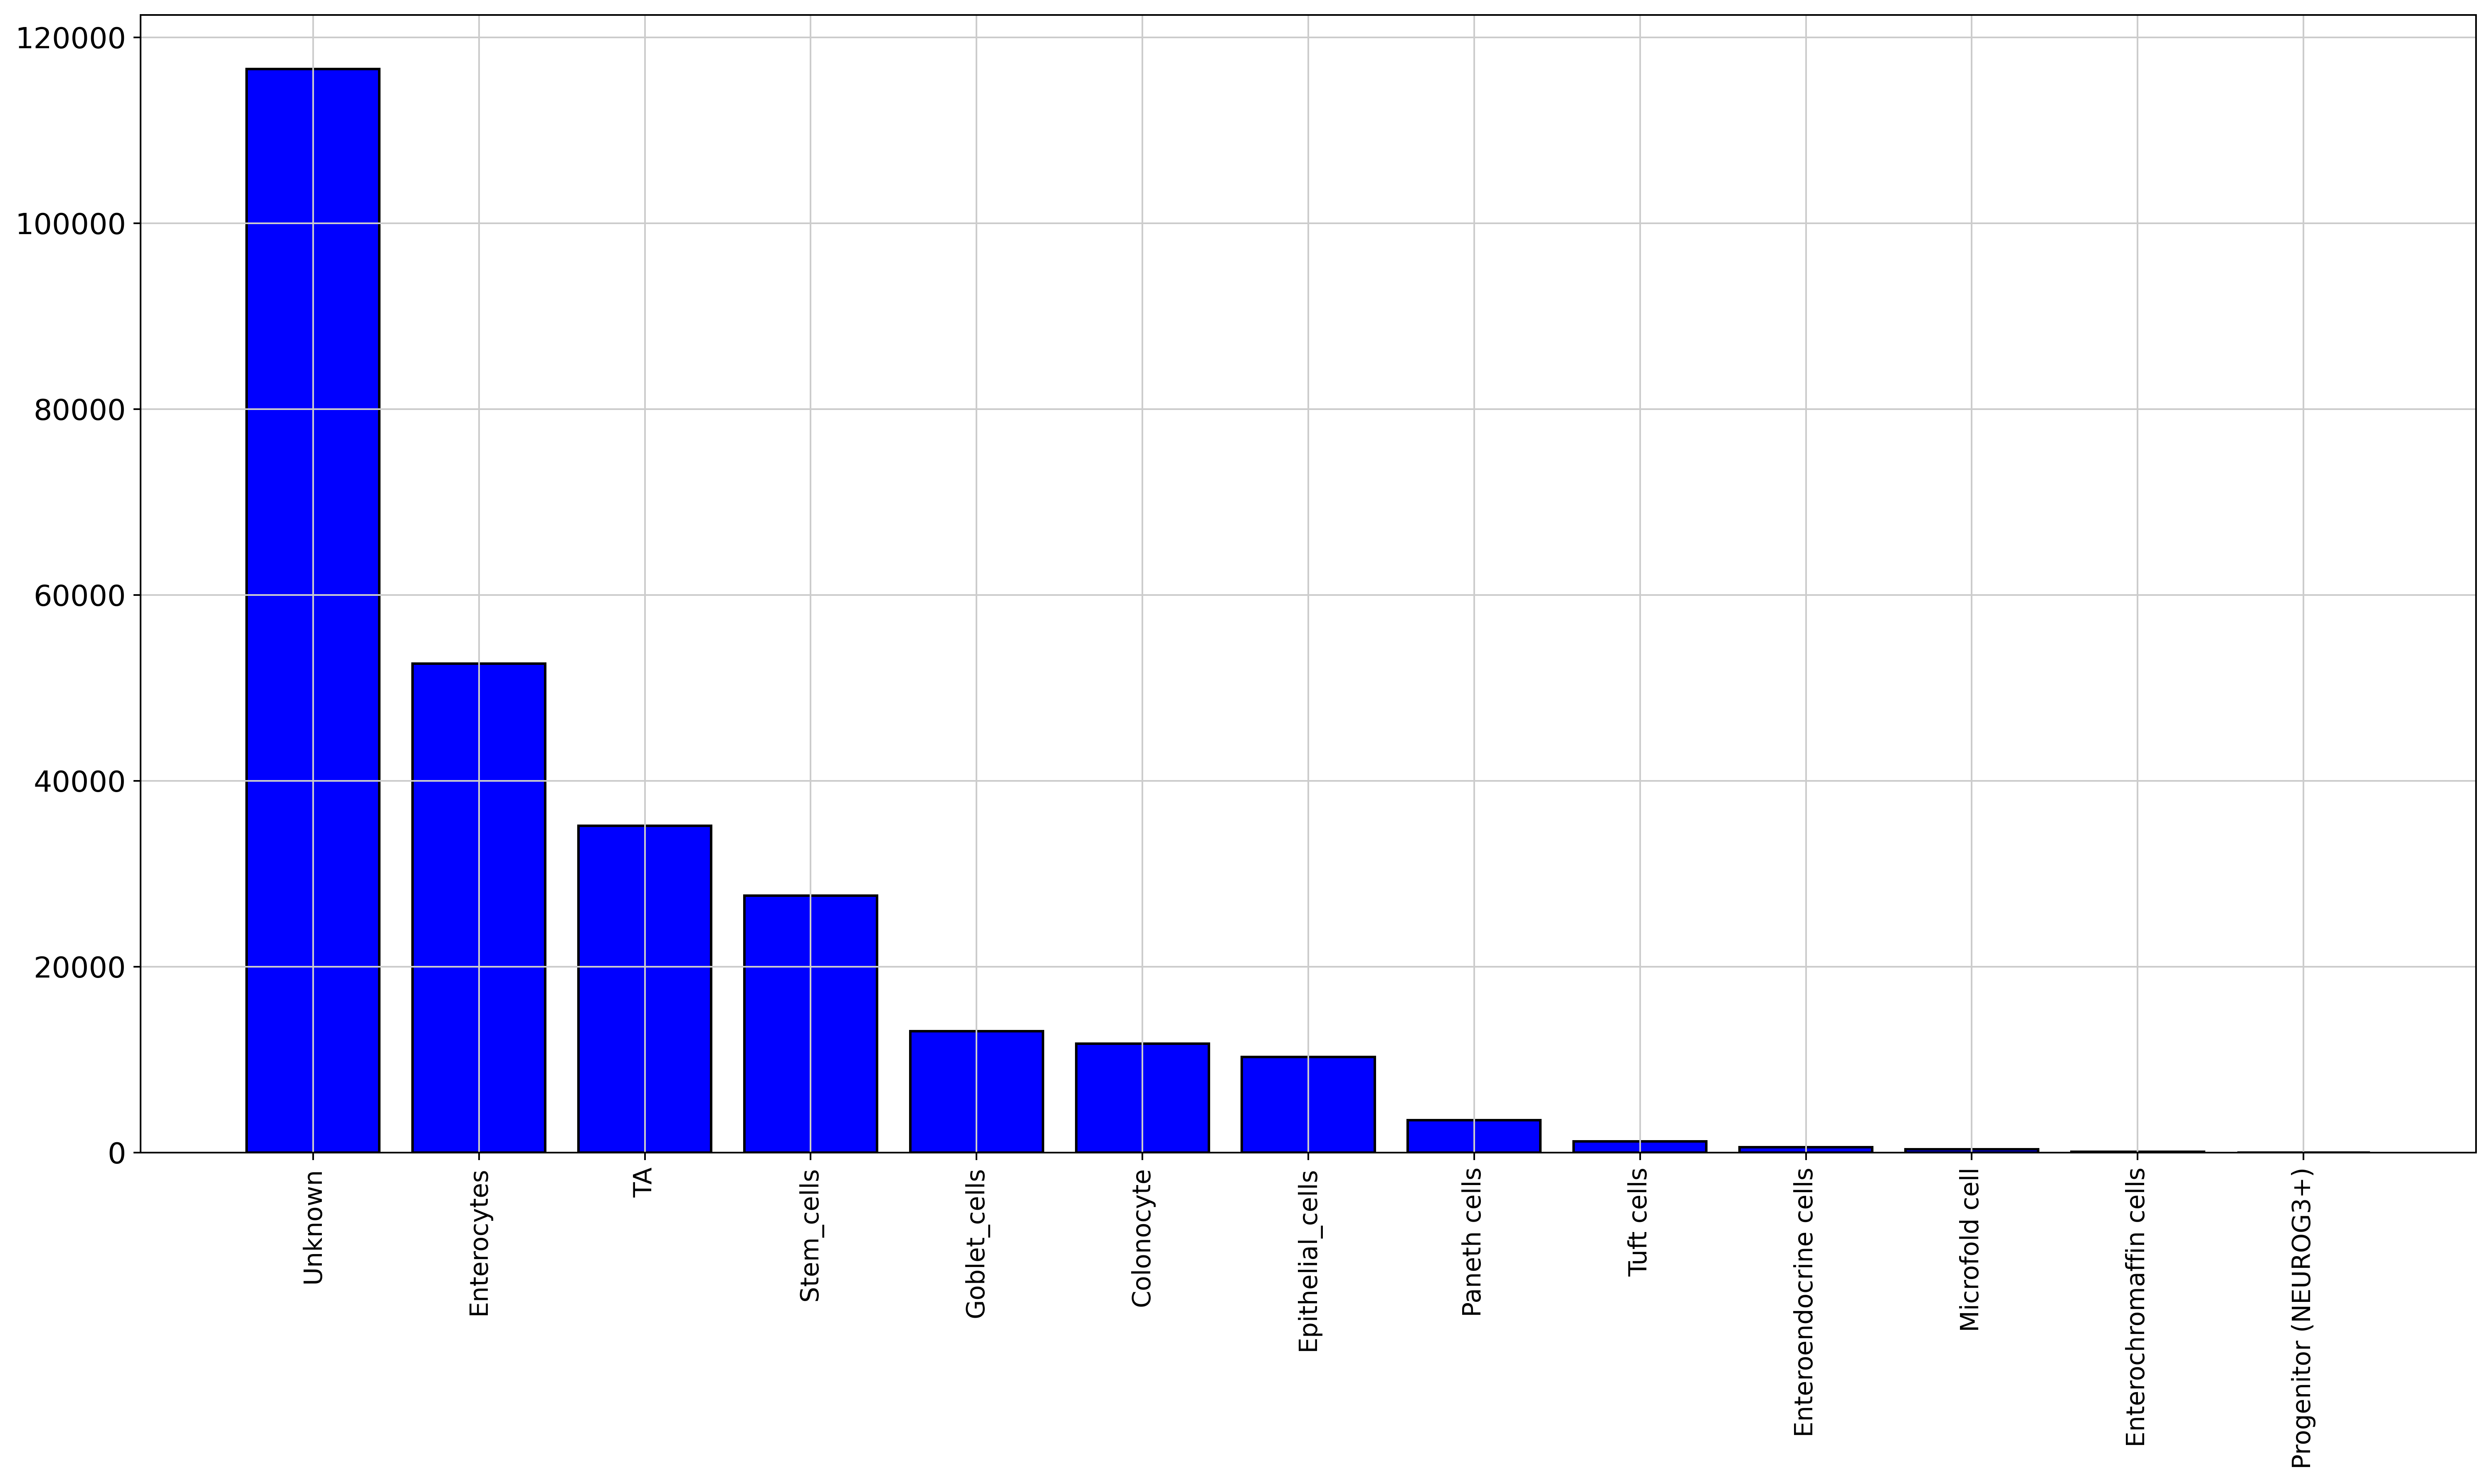

In [18]:
#Create a barplot of the number of cells per cell type in the epithelial_cells_fetal object
plt.figure(figsize = (20, 10))
plt.bar(adata.obs["seed_labels"].value_counts().index, adata.obs["seed_labels"].value_counts(), color = "blue", edgecolor = "black", linewidth = 1.2)
plt.xticks(rotation = 90, fontsize = 12)

+ Run scVI

In [19]:
adata.layers['counts'] = adata.X.copy()

In [20]:
scvi.model.SCVI.setup_anndata(adata, categorical_covariate_keys=['Donor_ID', 'Library_Preparation_Protocol', 'Study_name'],
                              labels_key = "seed_labels", layer = 'counts')

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [21]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scvi/model/_scvi.py:127: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [22]:
scvi_model.train(400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/400:   0%|                                                                                                                  | 0/400 [00:00<?, ?it/s]

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [1:06:36<00:00, 10.89s/it, v_num=1, train_loss_step=99.1, train_loss_epoch=101]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [1:06:36<00:00,  9.99s/it, v_num=1, train_loss_step=99.1, train_loss_epoch=101]


<Axes: xlabel='epoch'>

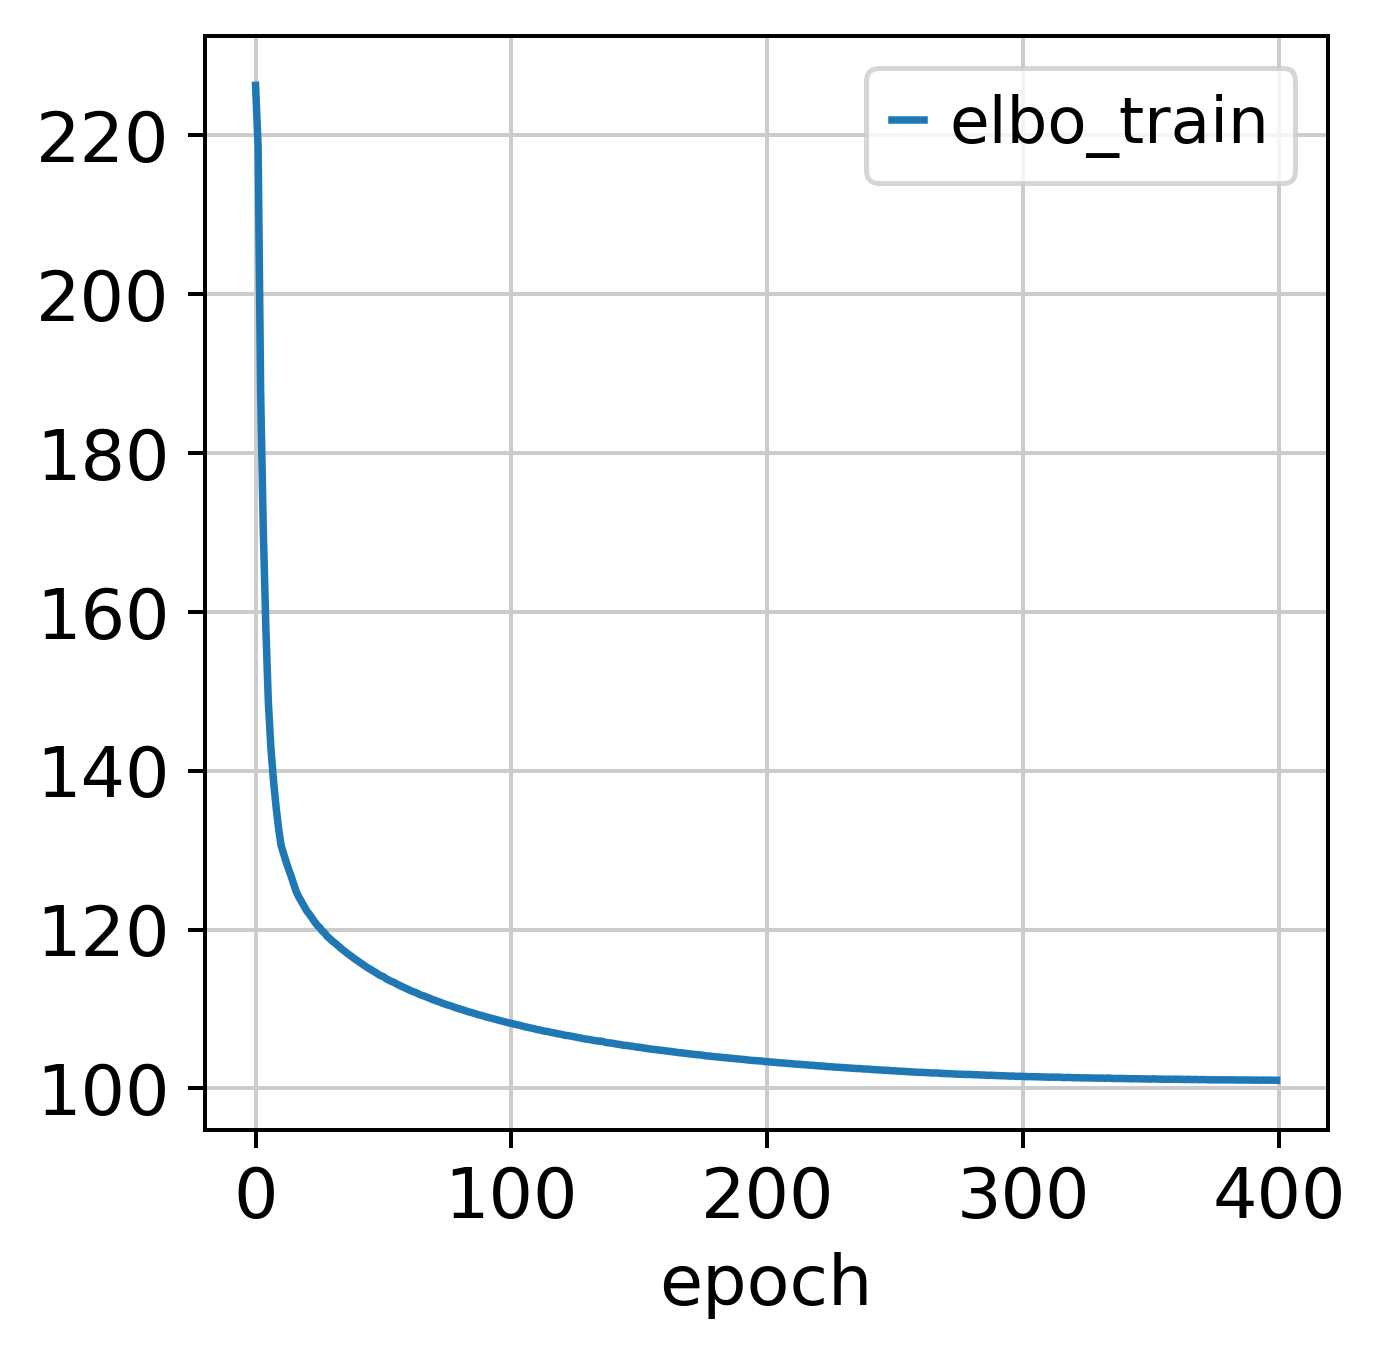

In [23]:
# plot training history
scvi_model.history['elbo_train'].plot()

In [24]:
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()

+ Transfer of annotations with scANVI

In [25]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scvi/model/_scanvi.py:140: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [26]:
scanvi_model.train(50)

INFO     Training for 50 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 50/50: 100%|██████████████████████████████████████████████████████| 50/50 [22:23<00:00, 22.91s/it, v_num=1, train_loss_step=167, train_loss_epoch=171]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████████████████████████████████████████████████| 50/50 [22:23<00:00, 26.87s/it, v_num=1, train_loss_step=167, train_loss_epoch=171]


In [27]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

In [28]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [29]:
adata.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/epithelial_scRNA_and_Xenium_data_scANVI.h5ad')

+ Visualize dataset

In [30]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:26)


In [31]:
adata.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/epithelial_scRNA_and_Xenium_data_scANVI.h5ad')

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

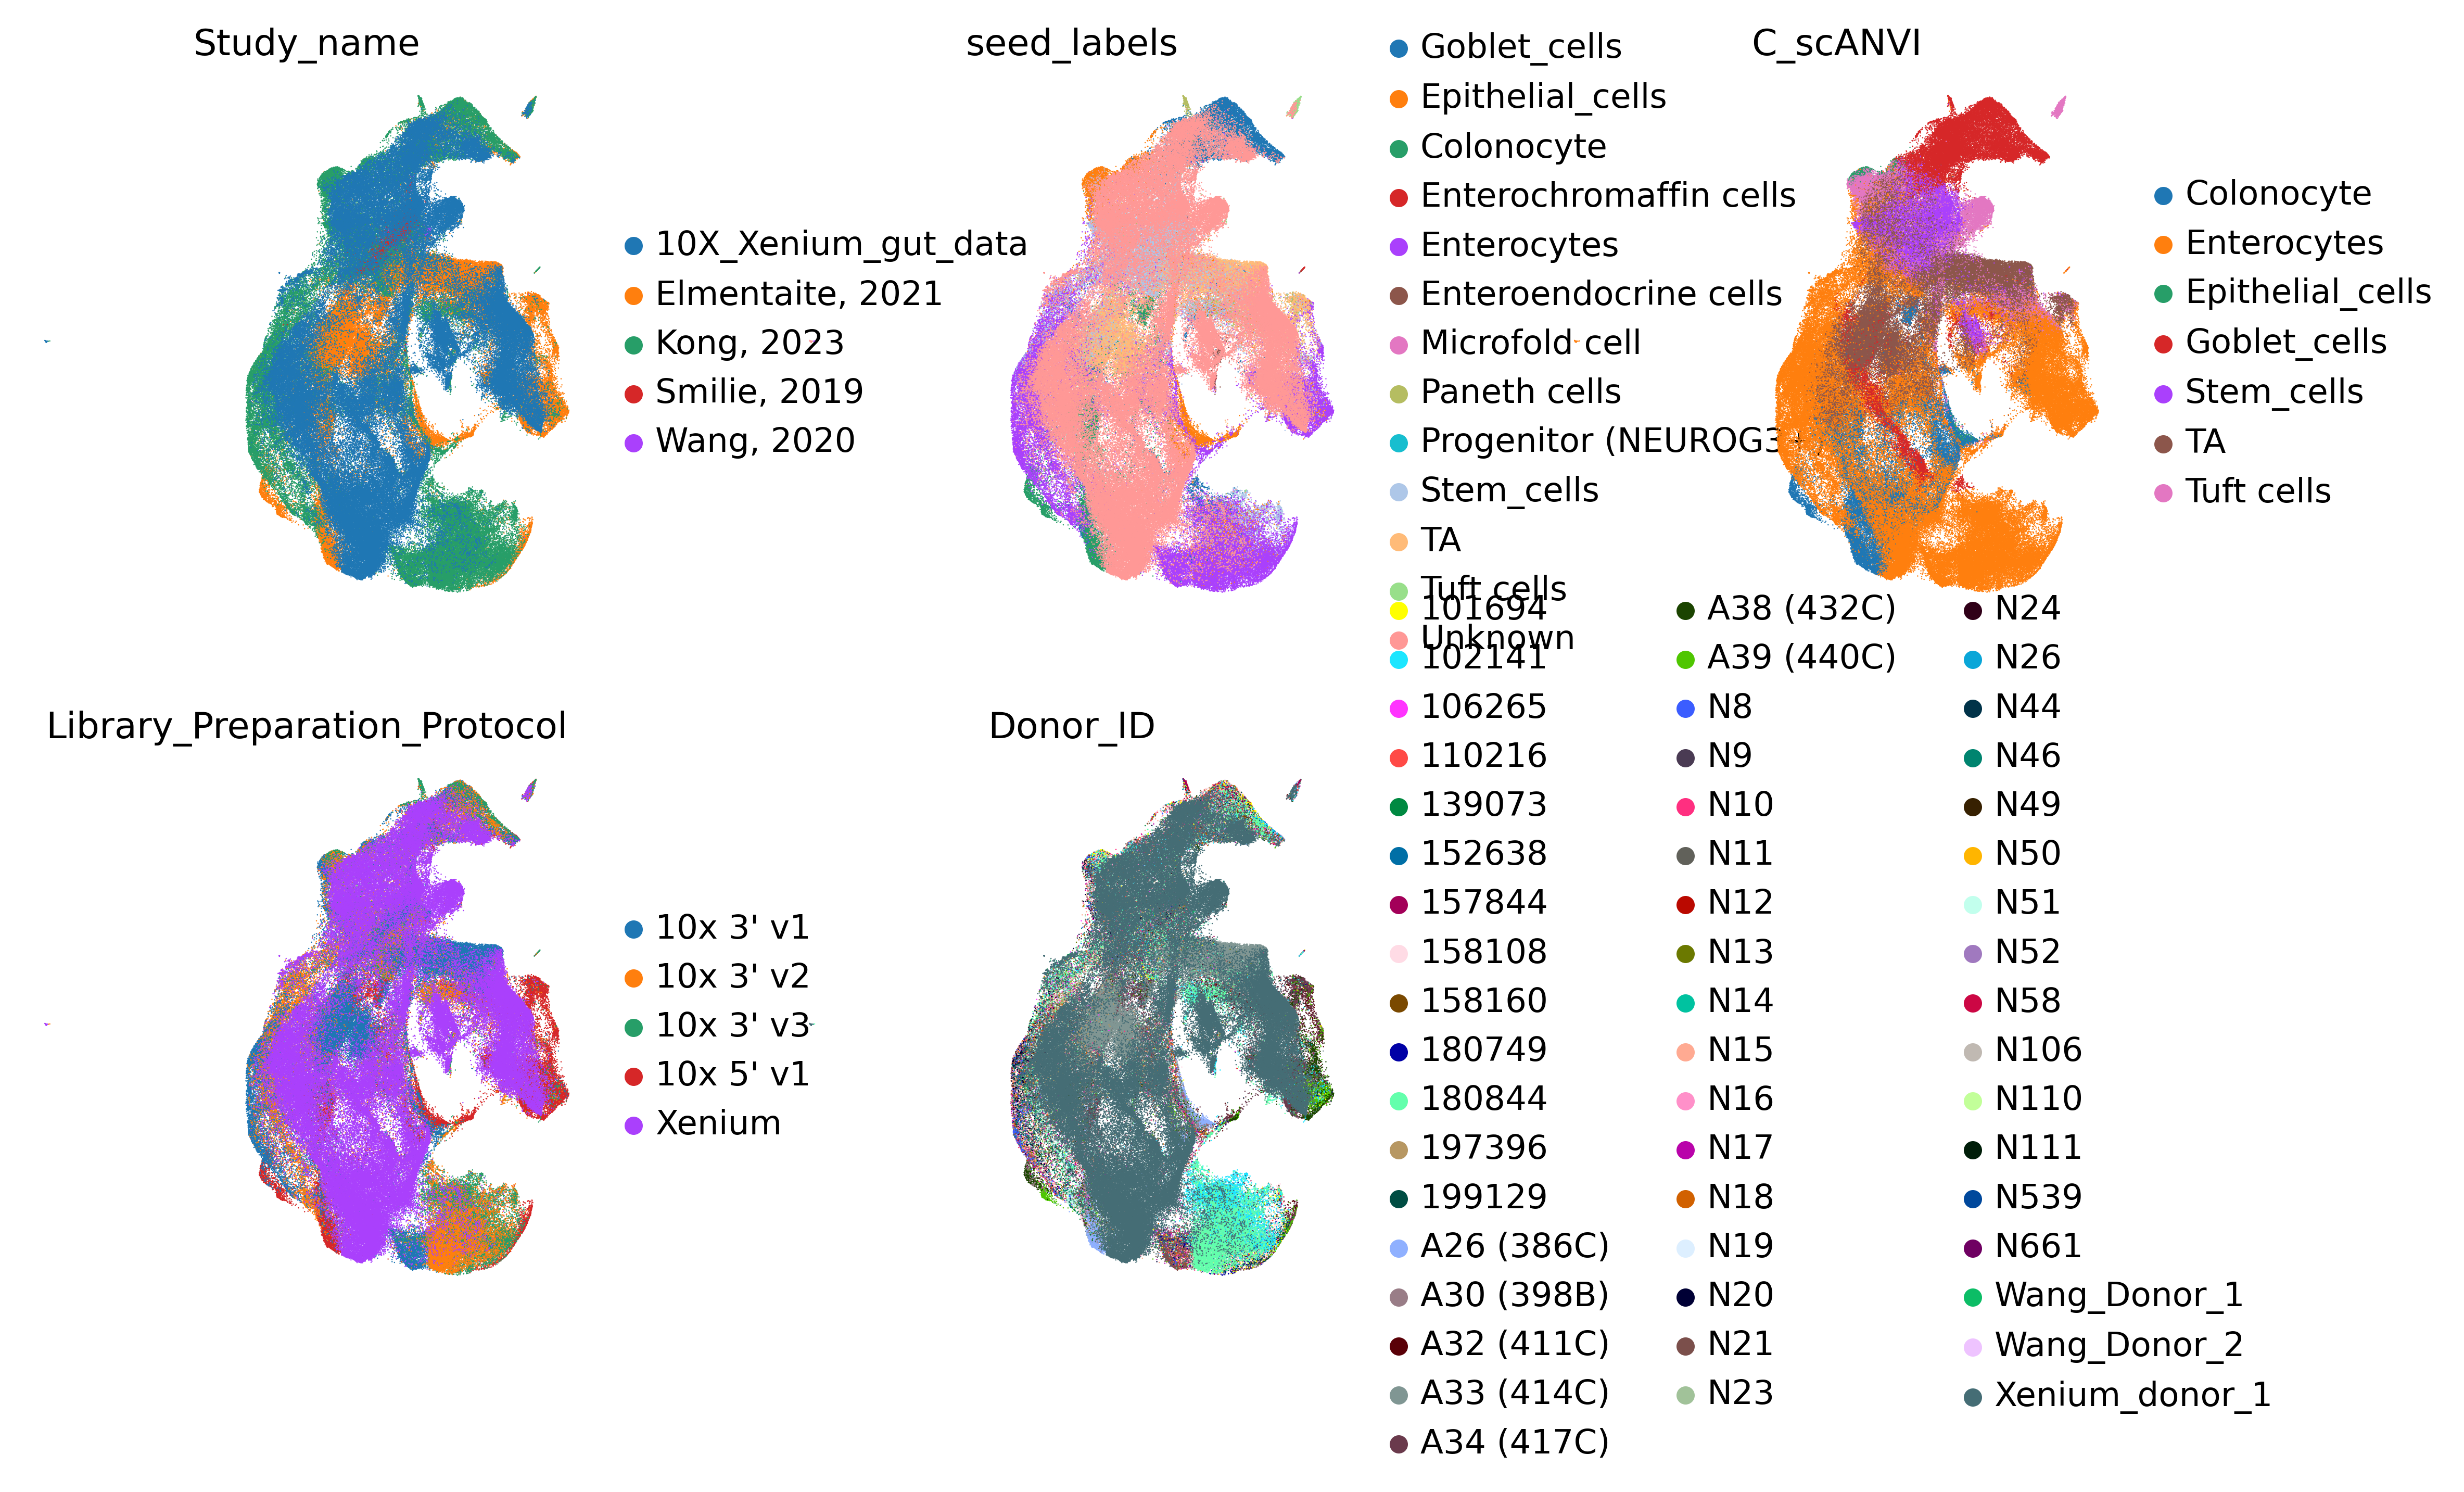

In [32]:
sc.pl.umap(adata, color = ['Study_name', 'seed_labels', 'C_scANVI', 'Library_Preparation_Protocol', 'Donor_ID'], ncols = 3, frameon = False, size = 1)

/tmp/ipykernel_1605700/3509242748.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['seed_labels', "C_scANVI"]).size().unstack(fill_value=0)


Text(0, 0.5, 'Observed')

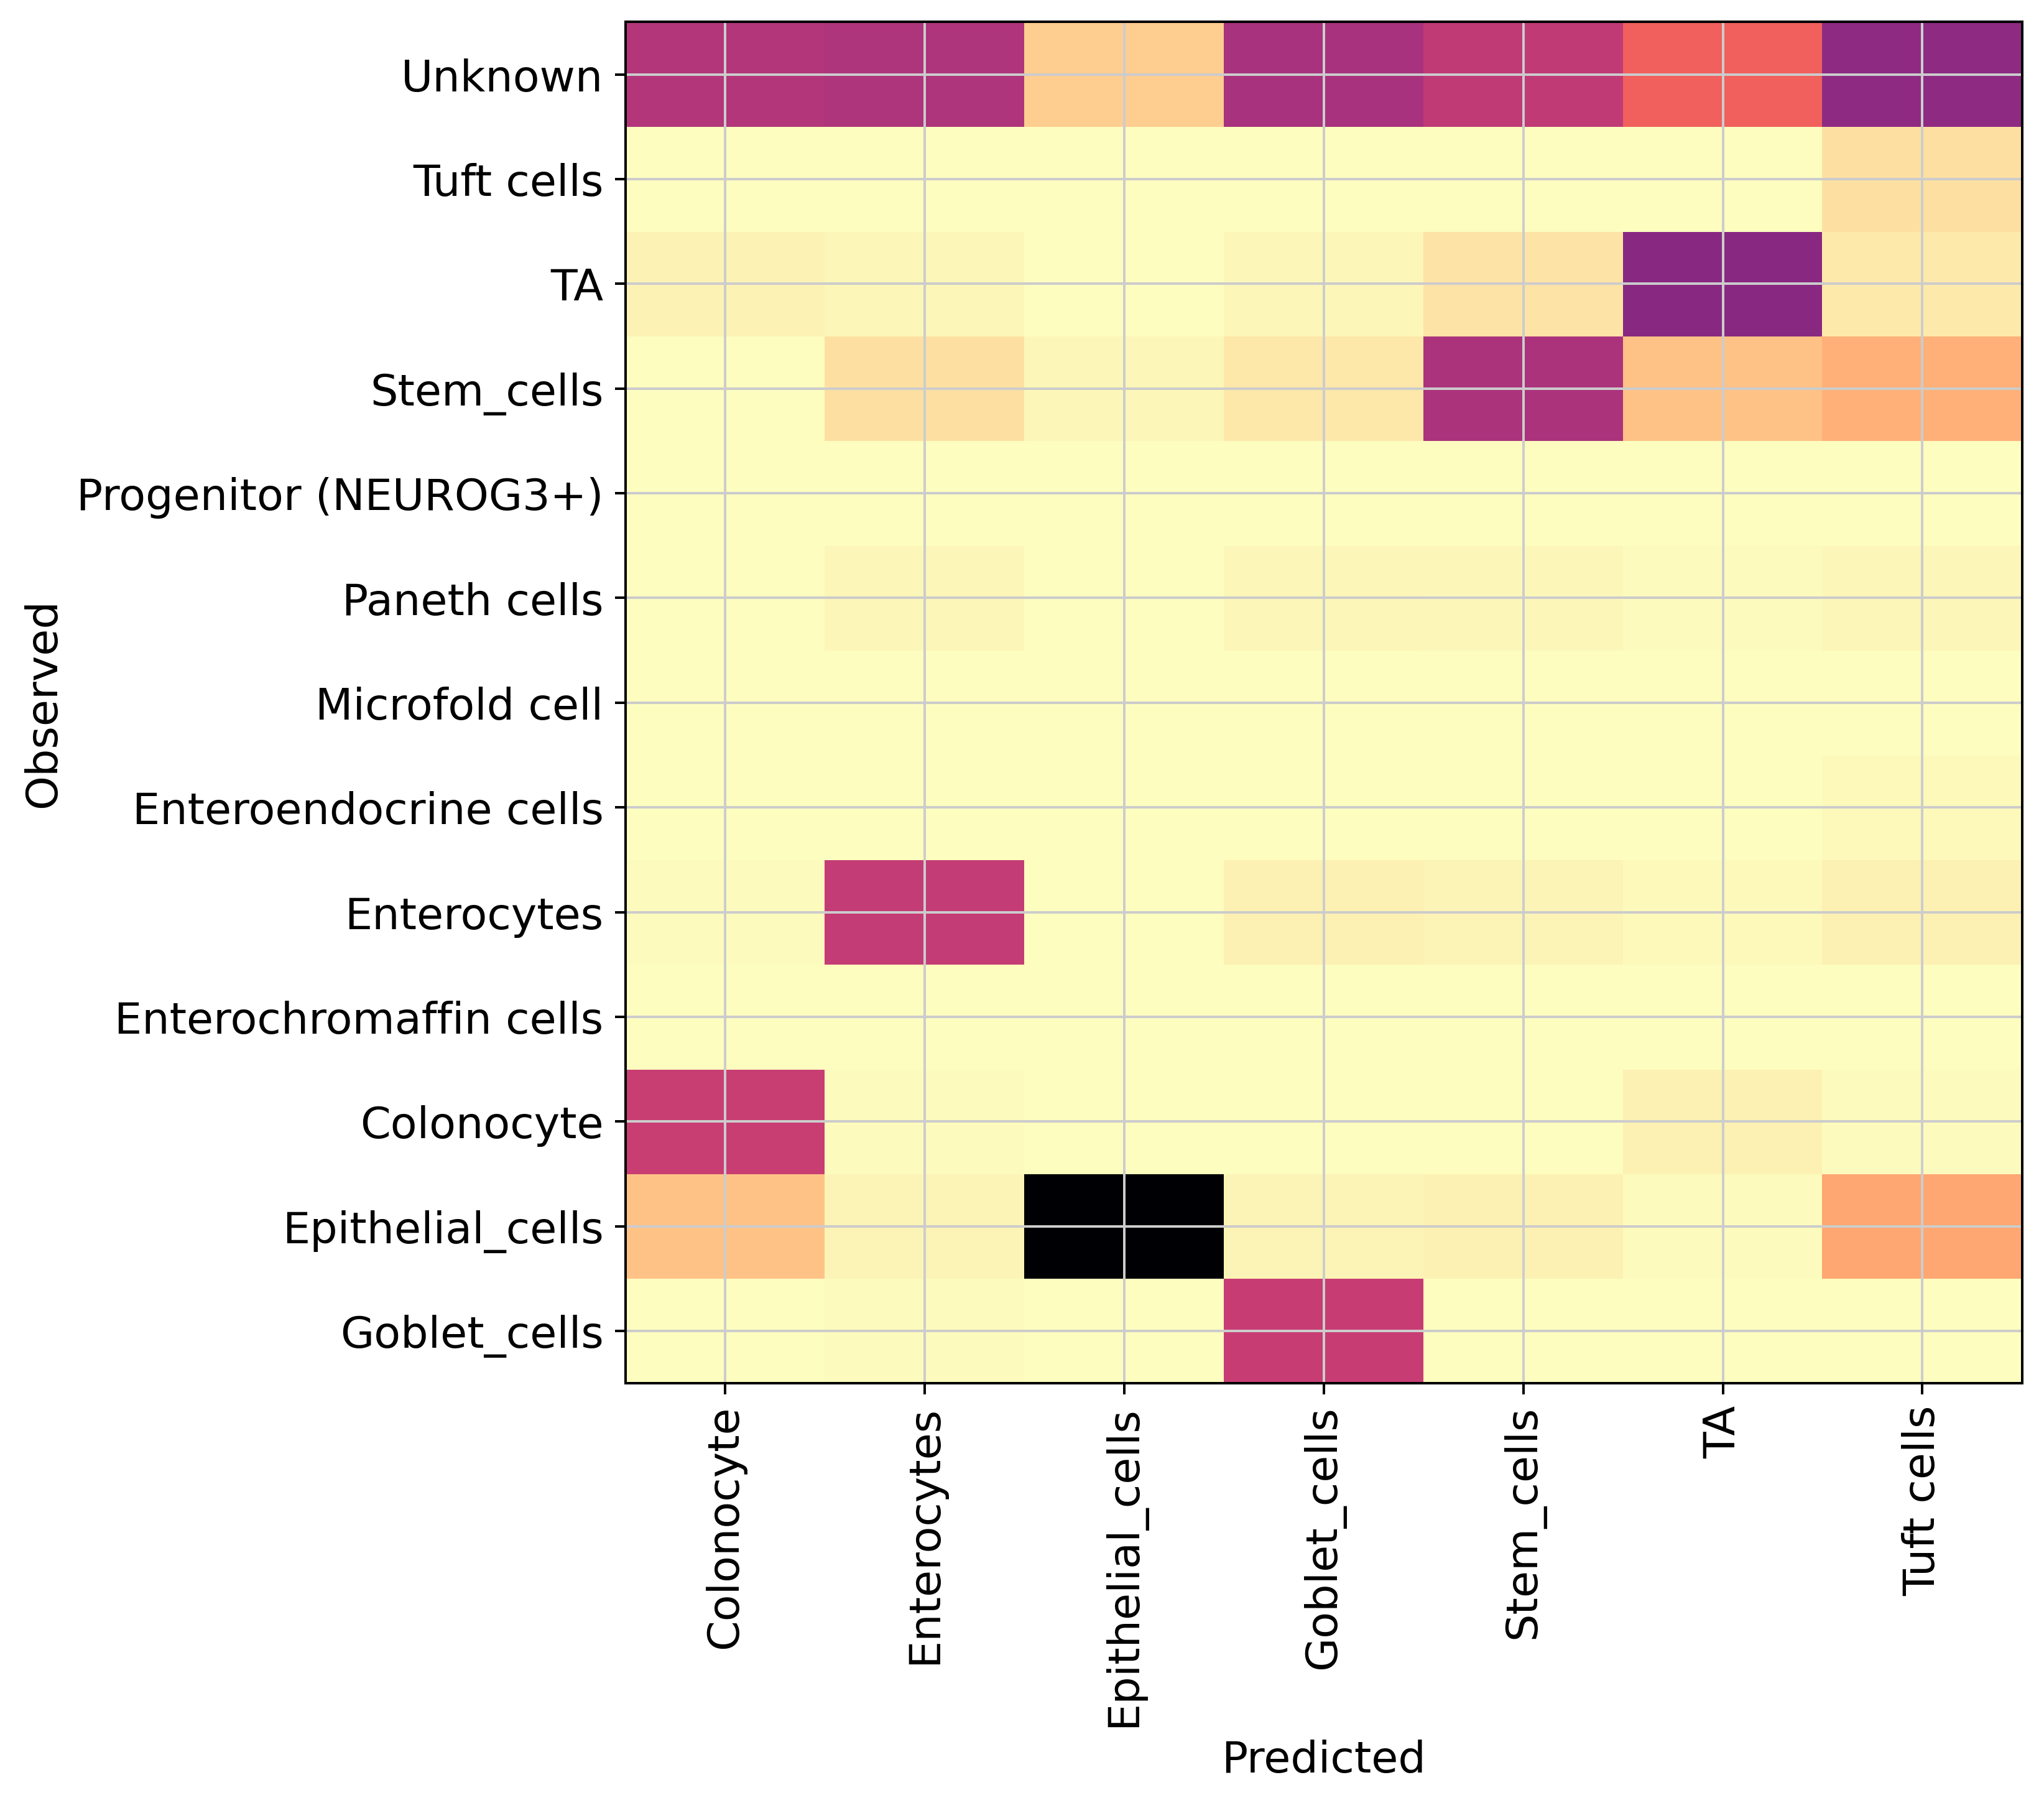

In [33]:
#Validation of the clusters
df = adata.obs.groupby(['seed_labels', "C_scANVI"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")